## **Fruit 360: Deep learning with CNN**
#### What is fruit 360?
Fruit 360 is A dataset of images containing fruits and vegetables. The total number of images is 90483 and separated into training set and test set in advance. There are 131 different types of fruit and veges, and Image size is 100x100 pixels.
Later we will try to train baseline CNN model and tuning parameters to find better model for this dataset.

### **Import libraries and dataset**

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.initializers import *
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.applications import VGG16
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img, img_to_array
import warnings
warnings.filterwarnings("ignore")

import os

        

### **Reading and Visualizing the Data**

Image shape (100, 100, 3)


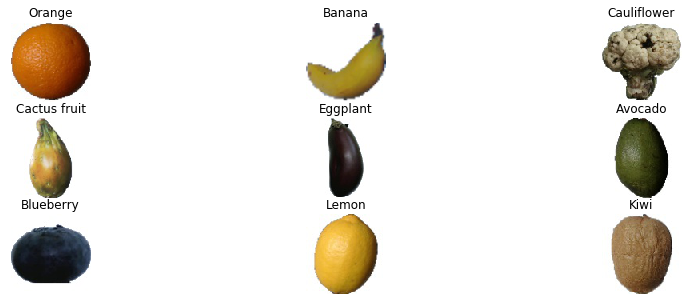

In [2]:
train_path = '/kaggle/input/fruits-360_dataset/fruits-360/Training/'
test_path = '/kaggle/input/fruits-360_dataset/fruits-360/Test/'

images = ['Orange', 'Banana', 'Cauliflower', 'Cactus fruit', 'Eggplant', 'Avocado', 'Blueberry','Lemon', 'Kiwi']
fig = plt.figure(figsize =(15,5))
for i in range(9):
    ax = fig.add_subplot(3,3,i+1,xticks=[],yticks=[])
    plt.title(images[i])
    plt.axis("off")
    ax.imshow(load_img(train_path + images[i] +"/0_100.jpg", target_size=(100,100)))

img = load_img(train_path + "Apple Braeburn/0_100.jpg", target_size=(100,100))
x = img_to_array(img)
print("Image shape",x.shape)

In [3]:
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)
test_datagen  = ImageDataGenerator(rescale = 1./255)
batch_size = 8
train_gen = train_datagen.flow_from_directory(
    train_path,
    target_size=(100, 100),
    batch_size=batch_size,
    class_mode='categorical')
test_gen = test_datagen.flow_from_directory(test_path,
                                                    target_size=(100, 100),
                                                    batch_size = batch_size,
                                                    class_mode = "categorical")

Found 67692 images belonging to 131 classes.
Found 22688 images belonging to 131 classes.


### **Baseline Convolution Neural Network**
Neural networks, also known as artificial neural networks (ANNs) or simulated neural networks (SNNs), are a subset of machine learning and are at the heart of deep learning algorithms. 
<img src="https://miro.medium.com/max/1400/1*vkQ0hXDaQv57sALXAJquxA.webp"/>
A Convolutional Neural Network (ConvNet/CNN) is a Deep Learning algorithm that can take in an input image, assign importance (learnable weights and biases) to various aspects/objects in the image, and be able to differentiate one from the other. The pre-processing required in a ConvNet is much lower as compared to other classification algorithms. While in primitive methods filters are hand-engineered, with enough training, ConvNets have the ability to learn these filters/characteristics.

Convolutional neural networks are distinguished from other neural networks by their superior performance with image, speech, or audio signal inputs. They have three main types of layers, which are:
- Convolutional layer
- Pooling layer
- Fully-connected (FC) layer

The convolutional layer is the first layer of a convolutional network. While convolutional layers can be followed by additional convolutional layers or pooling layers, the fully-connected layer is the final layer. With each layer, the CNN increases in its complexity, identifying greater portions of the image. Earlier layers focus on simple features, such as colors and edges. As the image data progresses through the layers of the CNN, it starts to recognize larger elements or shapes of the object until it finally identifies the intended object.

Here we build and train a baseline CNN model for this fruit image dataset at first.

In [4]:
cnnmodel = Sequential()
#add convlutional2D layer with 32 filters
cnnmodel.add(Conv2D(32, (3, 3), activation='relu', input_shape=(100,100,3)))
cnnmodel.add(MaxPooling2D((2, 2), strides=2))
cnnmodel.add(Conv2D(64, (3, 3), activation='relu'))
cnnmodel.add(MaxPooling2D((2, 2), strides=2))
cnnmodel.add(Dropout(0.35))
#enter fully connected layer
cnnmodel.add(Flatten())
cnnmodel.add(Dense(32, activation='relu'))
cnnmodel.add(Dense(131, activation='softmax'))
opt = Adam()
cnnmodel.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
cnnmodel.summary()
history = cnnmodel.fit_generator(generator = train_gen, steps_per_epoch = 255, epochs=20,validation_data=test_gen,verbose=1)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 98, 98, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 49, 49, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 47, 47, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 23, 23, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 23, 23, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 33856)             0         
_________________________________________________________________
dense (Dense)                (None, 32)                1083424   
__________

### **VGG**
VGG16 is a convolution neural net (CNN ) architecture which was used to win ILSVR(Imagenet) competition in 2014. It is considered to be one of the excellent vision model architecture till date. Most unique thing about VGG16 is that instead of having a large number of hyper-parameter they focused on having convolution layers of 3x3 filter with a stride 1 and always used same padding and maxpool layer of 2x2 filter of stride 2. It follows this arrangement of convolution and max pool layers consistently throughout the whole architecture. In the end it has 2 FC(fully connected layers) followed by a softmax for output. The 16 in VGG16 refers to it has 16 layers that have weights. This network is a pretty large network and it has about 138 million (approx) parameters.
<img src="https://media.geeksforgeeks.org/wp-content/uploads/20200219152207/new41.jpg"/>

In [36]:
vgg16 = Sequential()
#add convlutional2D layer with 64 filters
vgg16.add(Conv2D(64, (3, 3), activation='relu', padding="same", input_shape=(100,100,3)))
vgg16.add(Conv2D(64, (3, 3), activation='relu', padding="same"))
vgg16.add(MaxPooling2D((2, 2), strides=2))
vgg16.add(Conv2D(128, (3, 3), activation='relu', padding="same"))
vgg16.add(Conv2D(128, (3, 3), activation='relu', padding="same"))
vgg16.add(MaxPooling2D((2, 2), strides=2))
vgg16.add(Conv2D(256, (3, 3), activation='relu', padding="same"))
vgg16.add(Conv2D(256, (3, 3), activation='relu', padding="same"))
vgg16.add(Conv2D(512, (3, 3), activation='relu', padding="same"))
vgg16.add(Conv2D(512, (3, 3), activation='relu', padding="same"))
vgg16.add(Conv2D(512, (3, 3), activation='relu', padding="same"))
vgg16.add(MaxPooling2D((2, 2), strides=2))
vgg16.add(Conv2D(512, (3, 3), activation='relu', padding="same"))
vgg16.add(Conv2D(512, (3, 3), activation='relu', padding="same"))
vgg16.add(Conv2D(512, (3, 3), activation='relu', padding="same"))
vgg16.add(MaxPooling2D((2, 2), strides=2))
#enter fully connected layer
vgg16.add(Flatten())
vgg16.add(Dense(1024, activation='relu'))#lower the dense unit and batch_size below to avoid out of memory issue
vgg16.add(Dense(131, activation='softmax'))
opt = Adam()
vgg16.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
vgg16.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_146 (Conv2D)          (None, 100, 100, 64)      1792      
_________________________________________________________________
conv2d_147 (Conv2D)          (None, 100, 100, 64)      36928     
_________________________________________________________________
max_pooling2d_50 (MaxPooling (None, 50, 50, 64)        0         
_________________________________________________________________
conv2d_148 (Conv2D)          (None, 50, 50, 128)       73856     
_________________________________________________________________
conv2d_149 (Conv2D)          (None, 50, 50, 128)       147584    
_________________________________________________________________
max_pooling2d_51 (MaxPooling (None, 25, 25, 128)       0         
_________________________________________________________________
conv2d_150 (Conv2D)          (None, 25, 25, 256)       295168    
__________

In [ ]:

history2 = vgg16.fit_generator(generator = train_gen, steps_per_epoch = 255, epochs=20,validation_data=test_gen)

### **GoogleNet**
##### What is GoogleNet?

GoogLeNet is a deep convolutional neural network that was proposed by Szegedy et al. [1]. This network won the ImageNet Large-Scale Visual Recognition Challenge 2014 (ILSVRC-2014) where 92.3% classification performance was achieved. In particular, this model was designed in a special architecture that allows for increasing the depth and width of the network but keeping the computing resource. 
<img src="https://media.geeksforgeeks.org/wp-content/uploads/20200429201549/Inceptionv1_architecture.png" />

The GoogleNet Architecture is 22 layers deep, with 27 pooling layers included. There are 9 inception modules stacked linearly in total. The ends of the inception modules are connected to the global average pooling layer.
- The input size image is 224 × 224.
- are nine Inception blocks in this network.
- There are four max-pooling layers outside the Inception blocks, in which two layers are located between blocks 3–4 and block 7–8. These max-pooling layers help to reduce the size of the input data, thus reduce the model complexity as well as the computational cost.
- This network inherits the idea of using an average pooling layer from NiN, which helps to improve the model performance and reduce overfitting.
- A dropout layer (with 40%) is utilized before the linear layer. This is also an efficient regularization method to reduce the overfitting phenomena.
- The output layer uses the softmax activation function to give 1000 outputs which are corresponding to the number of categories in the ImageNet dataset.

In [38]:
from tensorflow.keras.layers import Concatenate
def Inception_block(input_layer, f1, f2_conv1, f2_conv3, f3_conv1, f3_conv5, f4): 
  # Input: 
  # - f1: number of filters of the 1x1 convolutional layer in the first path
  # - f2_conv1, f2_conv3 are number of filters corresponding to the 1x1 and 3x3 convolutional layers in the second path
  # - f3_conv1, f3_conv5 are the number of filters corresponding to the 1x1 and 5x5  convolutional layer in the third path
  # - f4: number of filters of the 1x1 convolutional layer in the fourth path

  # 1st path:
  path1 = Conv2D(filters=f1, kernel_size = (1,1), padding = 'same', activation = 'relu')(input_layer)

  # 2nd path
  path2 = Conv2D(filters = f2_conv1, kernel_size = (1,1), padding = 'same', activation = 'relu')(input_layer)
  path2 = Conv2D(filters = f2_conv3, kernel_size = (3,3), padding = 'same', activation = 'relu')(path2)

  # 3rd path
  path3 = Conv2D(filters = f3_conv1, kernel_size = (1,1), padding = 'same', activation = 'relu')(input_layer)
  path3 = Conv2D(filters = f3_conv5, kernel_size = (5,5), padding = 'same', activation = 'relu')(path3)

  # 4th path
  path4 = MaxPooling2D((3,3), strides= (1,1), padding = 'same')(input_layer)
  path4 = Conv2D(filters = f4, kernel_size = (1,1), padding = 'same', activation = 'relu')(path4)

  output_layer = concatenate([path1, path2, path3, path4], axis = -1)

  return output_layer


In [42]:
def extra_work(input_layer):
    work1= AveragePooling2D(pool_size = (5,5), strides = 3)(input_layer)
    work1= Conv2D(filters=128, kernel_size=(1,1), strides=1, padding='same', activation='relu')(work1)
    work1= Flatten()(work1)
    work1= Dense(1024, activation = 'relu')(work1)
    work1= Dropout(0.7)(work1)
    work1= Dense(131, activation = 'softmax')(work1)
    
    return work1

In [56]:
input_layer = Input(shape = (100, 100, 3))
X=Conv2D(64, (7,7), activation='relu', strides=2, padding="same")(input_layer)
X=MaxPooling2D((3, 3), strides=2)(X)
X=Conv2D(192, (3, 3), activation='relu', padding="same")(X)
X=MaxPooling2D((3, 3), strides=2)(X)
X=Inception_block(X, 64,  96, 128, 16, 32, 32)
X=Inception_block(X, 128,  128, 192, 32, 96, 64)
X=MaxPooling2D((3, 3), strides=2)(X)
X=Inception_block(X, 192,  96, 208, 16, 48, 64)
extrawork1=extra_work(X)
X=Inception_block(X, 160,  112, 224, 24, 64, 64)
X=Inception_block(X, 128,  128, 256, 24, 64, 64)
X=Inception_block(X, 112,  144, 288, 32, 64, 64)
extrawork2=extra_work(X)
X=Inception_block(X, 256,  160, 320, 32, 128, 128)
X=MaxPooling2D((3, 3), strides=2)(X)
X=Inception_block(X,256,  160, 320, 32, 128, 128)
X=Inception_block(X, 384,  192, 384, 48, 128, 128)
X = GlobalAveragePooling2D(name = 'GAPL')(X)
X = Dropout(0.4)(X)
X = Dense(131, activation = 'softmax')(X)
ggnet = Model(input_layer, X, name = 'GoogLeNet')
ggnet.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])
ggnet.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            (None, 100, 100, 3)  0                                            
__________________________________________________________________________________________________
conv2d_514 (Conv2D)             (None, 50, 50, 64)   9472        input_8[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_135 (MaxPooling2D (None, 24, 24, 64)   0           conv2d_514[0][0]                 
__________________________________________________________________________________________________
conv2d_515 (Conv2D)             (None, 24, 24, 192)  110784      max_pooling2d_135[0][0]          
__________________________________________________________________________________________________
max_poolin

In [ ]:
history3 = ggnet.fit_generator(generator = train_gen, steps_per_epoch = 255, epochs=20,validation_data=test_gen,verbose=1)

### **Tuning parameters**

#### Adjust network architecture

In [64]:
cnnmodel2 = Sequential()
#add 3 convlutional2D layer with 8, 16, 32 filters
cnnmodel2.add(Conv2D(8, (3, 3), activation='relu', input_shape=(100,100,3)))
cnnmodel2.add(MaxPooling2D((2, 2), strides=2))
cnnmodel2.add(Conv2D(16, (3, 3), activation='relu'))
cnnmodel2.add(MaxPooling2D((2, 2), strides=2))
cnnmodel2.add(Dropout(0.35))
cnnmodel2.add(Conv2D(32, (3, 3), activation='relu'))
cnnmodel2.add(MaxPooling2D((2, 2), strides=2))
#enter fully connected layer
cnnmodel2.add(Flatten())
#update dense layer units numbers to 512 units
cnnmodel2.add(Dense(512, activation='relu'))
cnnmodel2.add(Dense(131, activation='softmax'))
#keep using adam 
opt = Adam()
cnnmodel2.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
cnnmodel2.summary()
history4 = cnnmodel2.fit_generator(generator = train_gen, steps_per_epoch = 255, epochs=20,validation_data=test_gen,verbose=1)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_588 (Conv2D)          (None, 98, 98, 8)         224       
_________________________________________________________________
max_pooling2d_160 (MaxPoolin (None, 49, 49, 8)         0         
_________________________________________________________________
conv2d_589 (Conv2D)          (None, 47, 47, 16)        1168      
_________________________________________________________________
max_pooling2d_161 (MaxPoolin (None, 23, 23, 16)        0         
_________________________________________________________________
dropout_26 (Dropout)         (None, 23, 23, 16)        0         
_________________________________________________________________
conv2d_590 (Conv2D)          (None, 21, 21, 32)        4640      
_________________________________________________________________
max_pooling2d_162 (MaxPoolin (None, 10, 10, 32)        0         
__________

#### Adjust gradient estimation

In [99]:
cnnmodel3 = Sequential()
#add 3 convlutional2D layer with 8, 16, 32 filters
cnnmodel3.add(Conv2D(8, (3, 3), activation='relu', input_shape=(100,100,3)))
cnnmodel3.add(MaxPooling2D((2, 2), strides=2))
cnnmodel3.add(Conv2D(32, (3, 3), activation='relu'))
cnnmodel3.add(MaxPooling2D((2, 2), strides=2))
cnnmodel3.add(Conv2D(64, (3, 3), activation='relu'))
cnnmodel3.add(MaxPooling2D((2, 2), strides=2))
#enter fully connected layer
cnnmodel3.add(Flatten())
cnnmodel3.add(Dense(1024, activation='relu'))
cnnmodel3.add(Dense(131, activation='softmax'))
#change gradient estimation to rmsprop
opt = RMSprop()
cnnmodel3.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
cnnmodel3.summary()
history5 = cnnmodel3.fit_generator(generator = train_gen, steps_per_epoch = 255, epochs=20,validation_data=test_gen,verbose=1)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_707 (Conv2D)          (None, 98, 98, 8)         224       
_________________________________________________________________
max_pooling2d_273 (MaxPoolin (None, 49, 49, 8)         0         
_________________________________________________________________
conv2d_708 (Conv2D)          (None, 47, 47, 32)        2336      
_________________________________________________________________
max_pooling2d_274 (MaxPoolin (None, 23, 23, 32)        0         
_________________________________________________________________
conv2d_709 (Conv2D)          (None, 21, 21, 64)        18496     
_________________________________________________________________
max_pooling2d_275 (MaxPoolin (None, 10, 10, 64)        0         
_________________________________________________________________
flatten_68 (Flatten)         (None, 6400)              0         
__________

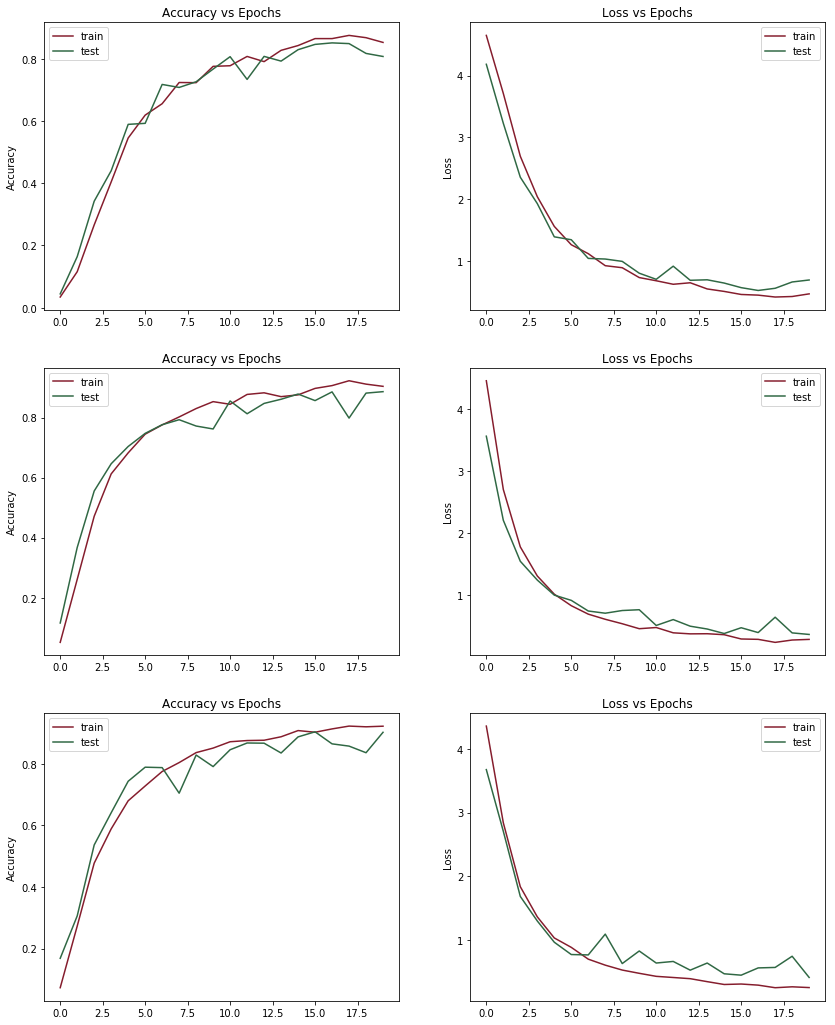

In [100]:
plt.figure(figsize=(14, 18))
plt.subplot(3,2,1)
epochs=np.arange(20)
plt.title('Accuracy vs Epochs')
plt.plot(epochs,history.history['acc'],label='train', color='#851D2D')
plt.ylabel('Accuracy')
plt.plot(epochs,history.history['val_acc'],label='test', color='#306844')
plt.legend()
plt.subplot(3,2,2)
plt.title('Loss vs Epochs')
plt.plot(epochs,history.history['loss'],label='train', color='#851D2D')
plt.ylabel('Loss')
plt.plot(epochs,history.history['val_loss'],label='test', color='#306844')
plt.legend()

plt.subplot(3,2,3)
epochs=np.arange(20)
plt.title('Accuracy vs Epochs')
plt.plot(epochs,history4.history['acc'],label='train', color='#851D2D')
plt.ylabel('Accuracy')
plt.plot(epochs,history4.history['val_acc'],label='test', color='#306844')
plt.legend()
plt.subplot(3,2,4)
plt.title('Loss vs Epochs')
plt.plot(epochs,history4.history['loss'],label='train', color='#851D2D')
plt.ylabel('Loss')
plt.plot(epochs,history4.history['val_loss'],label='test', color='#306844')
plt.legend()

plt.subplot(3,2,5)
epochs=np.arange(20)
plt.title('Accuracy vs Epochs')
plt.plot(epochs,history5.history['acc'],label='train', color='#851D2D')
plt.ylabel('Accuracy')
plt.plot(epochs,history5.history['val_acc'],label='test', color='#306844')
plt.legend()
plt.subplot(3,2,6)
plt.title('Loss vs Epochs')
plt.plot(epochs,history5.history['loss'],label='train', color='#851D2D')
plt.ylabel('Loss')
plt.plot(epochs,history5.history['val_loss'],label='test', color='#306844')
plt.legend()
plt.show()

### **Conclusion**
The baseline CNN model can reached 80% accuracy, after adjust network architecture and gradient estimation method to RMSprop, mmodel with 3 convlutional2D ,3 maxpooling layers and 2 dense layers can finally have accuracy be 90%.

### **Reference**
[1] https://www.kaggle.com/code/shivamb/how-autoencoders-work-intro-and-usecases<br/>
[2] https://medium.com/mlearning-ai/implementation-of-googlenet-on-keras-d9873aeed83c<br/>
[3] https://en.wikipedia.org/wiki/Convolutional_neural_network<br/>

Googlenet inception_block code are cited from [2]

### **License**
MIT License

Copyright (c) 2022 Yanping Fu

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.